In [12]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [14]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [15]:
list_of_tickers = ["SPY", "AGG"]
end_date = datetime.now()
start_date = end_date + timedelta(-365)
df = get_historical_data(list_of_tickers, start_date, end_date,  output_format='pandas')
df.head() 


SPY                                        AGG                  \
              open    high     low   close     volume    open    high     low   
date                                                                            
2018-10-01  292.11  292.93  290.98  291.73   62078937  105.35  105.35  105.20   
2018-10-02  291.56  292.36  291.14  291.56   47258227  105.32  105.46  105.25   
2018-10-03  292.74  293.21  291.32  291.72   64694594  105.22  105.24  104.75   
2018-10-04  291.18  291.24  287.66  289.44  111545910  104.65  104.72  104.47   
2018-10-05  289.69  290.27  286.22  287.82  105951698  104.46  104.48  104.19   

                             
             close   volume  
date                         
2018-10-01  105.24  3517615  
2018-10-02  105.36  6912595  
2018-10-03  104.86  2540483  
2018-10-04  104.56  5268197  
2018-10-05  104.33  3460512

In [16]:
# delete extra columns 
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPY,AGG
,close,close
date,,
2018-10-01,291.73,105.24
2018-10-02,291.56,105.36
2018-10-03,291.72,104.86
2018-10-04,289.44,104.56
2018-10-05,287.82,104.33


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [17]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
avg_daily_return_SPY = daily_returns.mean()['SPY']['close']
avg_daily_return_AGG = daily_returns.mean()['AGG']['close']
avg_daily_return_AGG

0.000292545882004136

In [18]:
# Calculate volatility
std_dev_daily_return_SPY = daily_returns.std()['SPY']['close']
std_dev_daily_return_AGG = daily_returns.std()['AGG']['close']
std_dev_daily_return_SPY 

0.010617872571949955

In [19]:
# Save the last day's closing price
SPY_last_price = df['SPY']['close'][-1]
AGG_last_price = df['AGG']['close'][-1]


In [20]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [25]:
# Run the Monte Carlo Simulation
# Initialize empty dataframe 
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
# run simulation 500 times 
for n in range(number_simulations):
    simulated_SPY_prices = [SPY_last_price]
    simulated_AGG_prices = [AGG_last_price]
# simulate for 252 * 30  
    for i in range(number_records):
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
# Append a simulated prices of each simulation to DataFrame
        simulated_SPY_prices.append(simulated_SPY_price)
        simulated_AGG_prices.append(simulated_AGG_price)
# Append simulated prices in sim df 
simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
# Calculate the daily returns of simulated prices
simulated_daily_returns = simulated_price_df.pct_change()
# portfolio weights (60% SPY; 40% AGG)
weights = [0.60,0.40]


In [41]:
#daily return with weight
portfolio_daily_returns = simulated_daily_returns.dot(weights)
# Calculate the normalized, cumulative return series
portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
# print
portfolio_cumulative_returns.head() 

,499
0,1.000000
1,0.994762
2,0.998045
3,1.001007
4,1.001645


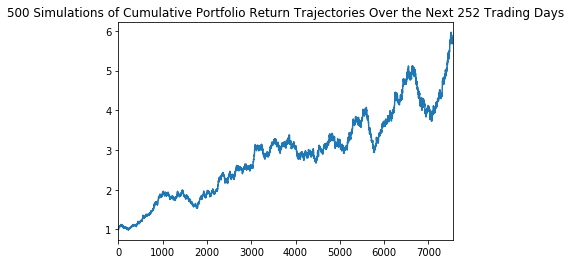

In [42]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title) 

In [28]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

499    5.679559
Name: 7560, dtype: float64

In [34]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

499    5.679559
Name: 7560, dtype: float64

In [35]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    5.679559
0.95    5.679559
Name: 7560, dtype: float64

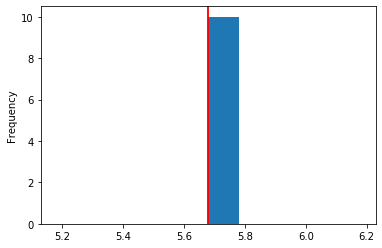

In [31]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [43]:
confidence_interval2=ending_cumulative_returns.quantile(q=[0.1, 0.5,0.9])
confidence_interval2

0.1    5.679559
0.5    5.679559
0.9    5.679559
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [44]:
# Investment 
initial_investment=20000
confidence_interval2.quantile(q=[0.1, 0.5,0.9])*initial_investment


0.1    113591.175844
0.5    113591.175844
0.9    113591.175844
Name: 7560, dtype: float64

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [45]:
retirement = 0.04 * (initial_investment * confidence_interval2.quantile(.1))
retirement

4543.647033760582

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [47]:
initial_investment=30000
retirement = 0.04 * (initial_investment * confidence_interval2.quantile(.1))
retirement

6815.470550640874

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE